In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
images = []
labels = []
for subfolder in tqdm(os.listdir('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset')):
    subfolder_path = os.path.join('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})

100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


In [3]:
df

image             label
0     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
1     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
2     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
3     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
4     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
...                                                 ...               ...
6395  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented
6396  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented
6397  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented
6398  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented
6399  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented

[6400 rows x 2 columns]

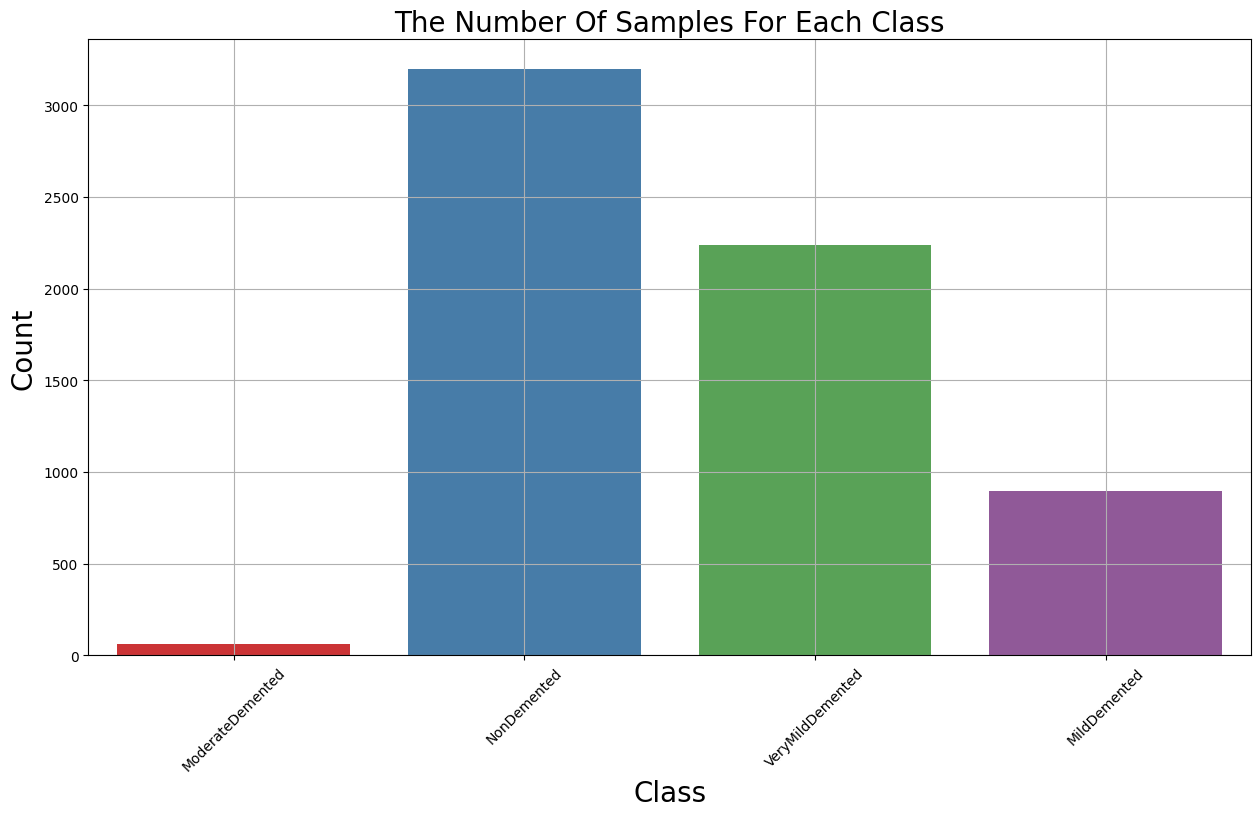

In [4]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

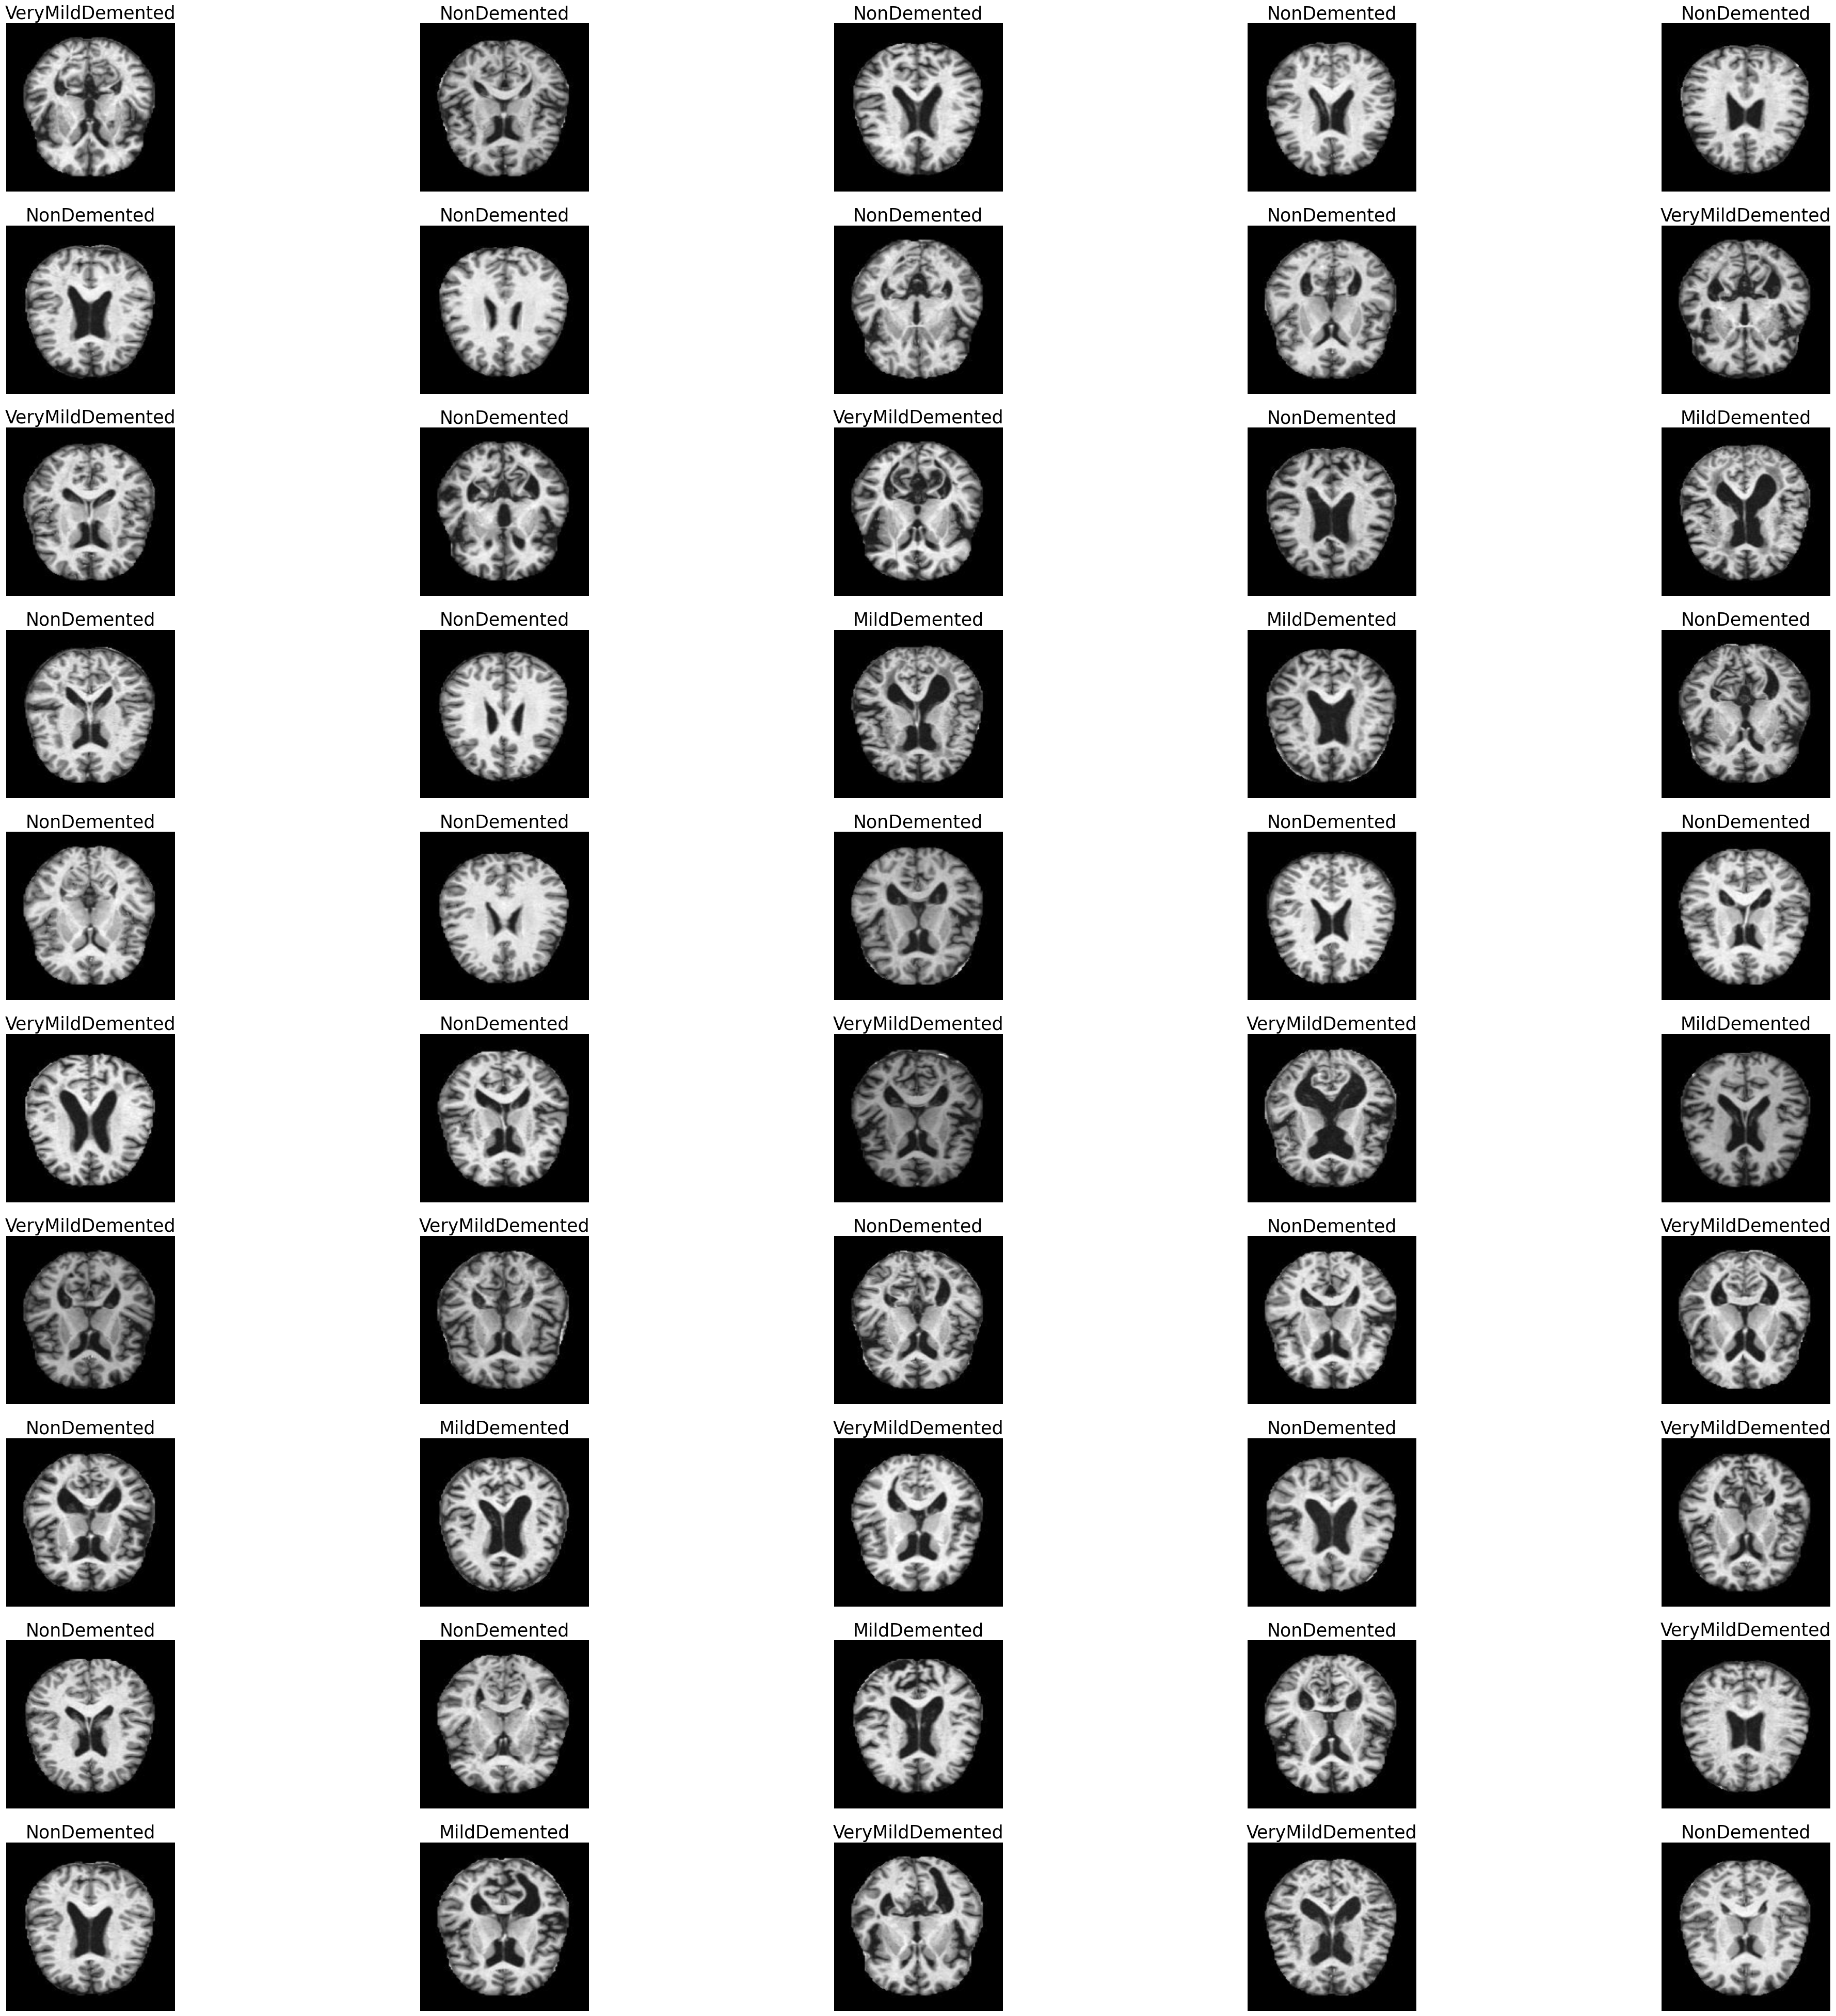

In [5]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

In [6]:
Size = (176, 176)
work_dr = ImageDataGenerator(
    rescale=1./255
    )
train_data_gen = work_dr.flow_from_dataframe(df, x_col='image', y_col='label', target_size=Size, batch_size=6500, shuffle=False)

Found 6400 validated image filenames belonging to 4 classes.


In [7]:
train_data, train_labels = train_data_gen.next()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train_data,train_labels,test_size=0.2,random_state=5)

In [9]:
X_train[0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

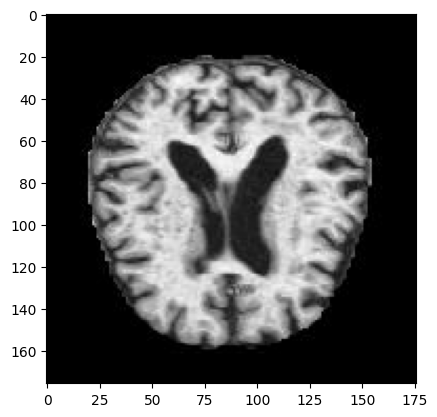

In [10]:
plt.imshow(X_train[0])

In [11]:
cnn = models.Sequential([
    #cnn
    layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu',  input_shape=(176, 176, 3)),
    layers.MaxPooling2D((2,2), padding='same'),
    layers.Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu'),
    layers.MaxPooling2D((2,2), padding='same'),
    layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2), padding='same'),
    #dense
    layers.Flatten(),
    layers.Dense(1024,activation='relu'),
     # Output layer
    layers.Dense(4, activation='softmax')
])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 88, 88, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 44, 44, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 22, 22, 128)       0

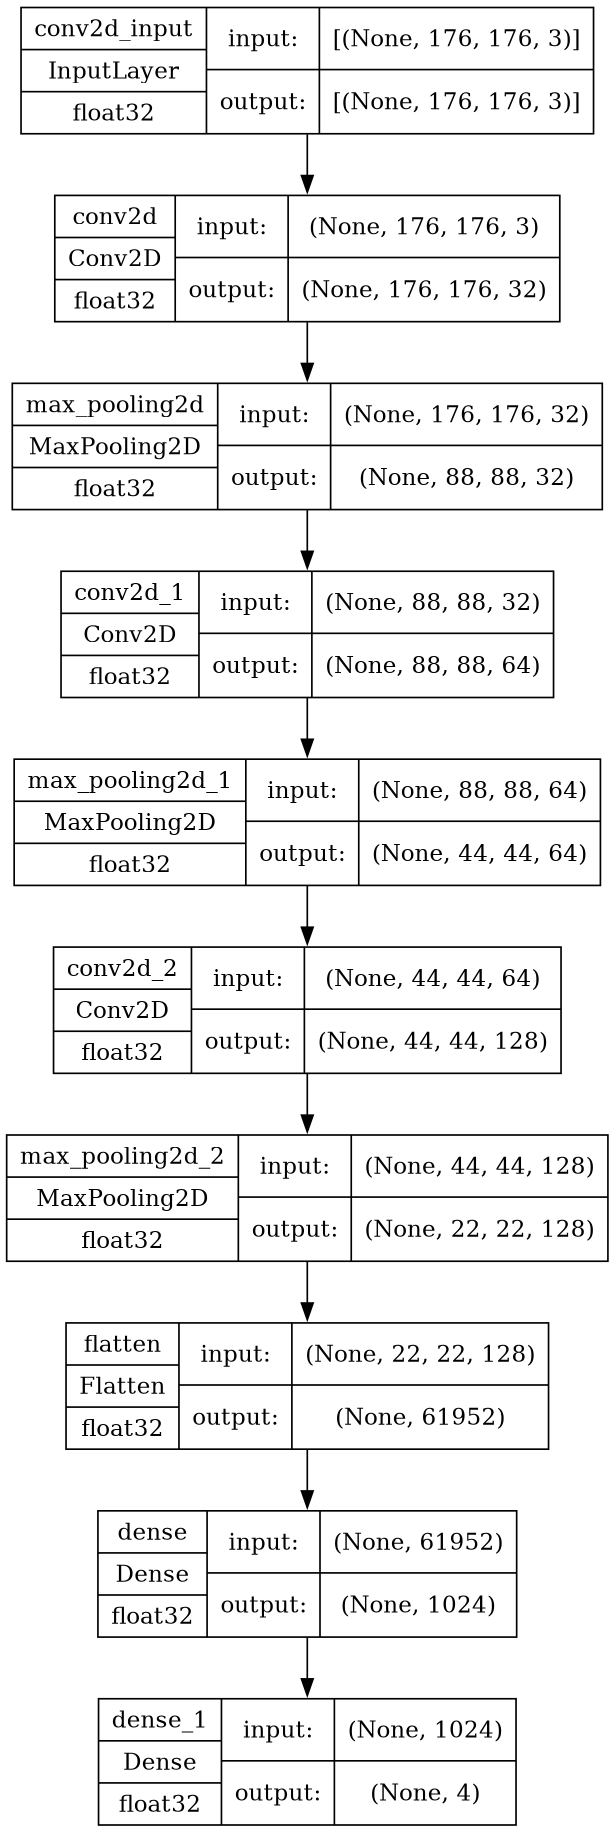

In [12]:
tf.keras.utils.plot_model(cnn, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [13]:
cnn.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
cnn.fit(X_train, y_train, epochs=10)

Epoch 1/10
160/160 [==============================] - 22s 39ms/step - loss: 1.0105 - accuracy: 0.5400
Epoch 2/10
160/160 [==============================] - 6s 39ms/step - loss: 0.6497 - accuracy: 0.7215
Epoch 3/10
160/160 [==============================] - 6s 40ms/step - loss: 0.3133 - accuracy: 0.8795
Epoch 4/10
160/160 [==============================] - 6s 40ms/step - loss: 0.1280 - accuracy: 0.9557
Epoch 5/10
160/160 [==============================] - 6s 39ms/step - loss: 0.0474 - accuracy: 0.9836
Epoch 6/10
160/160 [==============================] - 6s 40ms/step - loss: 0.0422 - accuracy: 0.9861
Epoch 7/10
160/160 [==============================] - 6s 40ms/step - loss: 0.0079 - accuracy: 0.9988
Epoch 8/10
160/160 [==============================] - 6s 40ms/step - loss: 0.0220 - accuracy: 0.9936
Epoch 9/10
160/160 [==============================] - 6s 40ms/step - loss: 0.0434 - accuracy: 0.9854
Epoch 10/10
160/160 [==============================] - 6s 40ms/step - loss: 0.0167 - accur

In [15]:
cnn.evaluate(X_test, y_test)

40/40 [==============================] - 1s 12ms/step - loss: 0.0613 - accuracy: 0.9742


[0.0613410659134388, 0.9742187261581421]

In [16]:
predictions = cnn.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)
df_1 = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
df_1

40/40 [==============================] - 1s 11ms/step


Actual  Prediction
0          3           3
1          2           2
2          3           2
3          2           2
4          2           2
...      ...         ...
1275       2           2
1276       2           2
1277       3           3
1278       2           2
1279       0           0

[1280 rows x 2 columns]

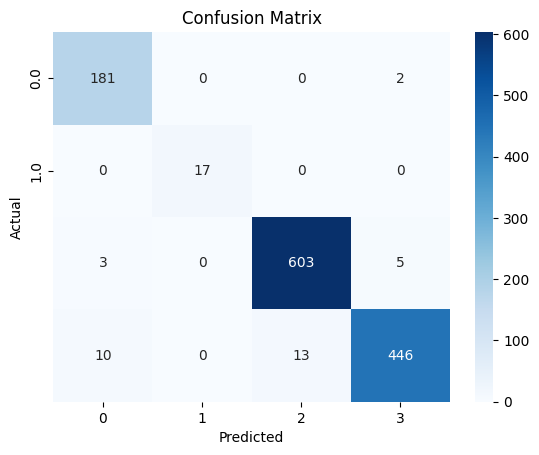

In [17]:
conf_matrix = confusion_matrix(y_test_, y_pred)

# Plot confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_pred), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
ClassificationReport = classification_report(y_test_,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.93      0.99      0.96       183
           1       1.00      1.00      1.00        17
           2       0.98      0.99      0.98       611
           3       0.98      0.95      0.97       469

    accuracy                           0.97      1280
   macro avg       0.97      0.98      0.98      1280
weighted avg       0.97      0.97      0.97      1280



# Balancing dataset

In [19]:
# Specify the test size and random seed as needed
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Display the shapes of the training and testing DataFrames
print("Training DataFrame shape:", train_df.shape)
print("Testing DataFrame shape:", test_df.shape)

Training DataFrame shape: (5120, 2)
Testing DataFrame shape: (1280, 2)


In [20]:
# Assuming 'X_test' and 'y_test' are your features and labels for the test set
test_data_gen = ImageDataGenerator(rescale=1./255)

# Create test data generator
test_data_gen = test_data_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col='label',
    target_size=Size,
    batch_size=1280,  # Adjust the batch size based on your preferences
    shuffle=False
)

Found 1280 validated image filenames belonging to 4 classes.


In [21]:
x_test, Y_test = test_data_gen.next()
# Display the shapes of X_test and y_test
print("X_test shape:", x_test.shape)
print("y_test shape:", Y_test.shape)

X_test shape: (1280, 176, 176, 3)
y_test shape: (1280, 4)


In [22]:
# Get unique class labels in the training set
unique_classes_train = train_df['label'].unique()

# Create an array to store DataFrames for each class
class_dfs_train = np.empty(len(unique_classes_train), dtype=object)

# Iterate over unique classes in the training set
for i, class_label in enumerate(unique_classes_train):
    # Filter training DataFrame for the current class
    class_df_train = train_df[train_df['label'] == class_label]

    # Store the DataFrame in the array
    class_dfs_train[i] = class_df_train

    # Print the size of the current class in the training set
    print(f"Class: {class_label}, Size (Training): {len(class_df_train)}")
    print(class_df_train.head())  # Display the first few rows of each class DataFrame
    print("=" * 50)

Class: NonDemented, Size (Training): 2534
                                                  image        label
1859  /kaggle/input/alzheimers-dataset-4-class-of-im...  NonDemented
3238  /kaggle/input/alzheimers-dataset-4-class-of-im...  NonDemented
2646  /kaggle/input/alzheimers-dataset-4-class-of-im...  NonDemented
471   /kaggle/input/alzheimers-dataset-4-class-of-im...  NonDemented
3409  /kaggle/input/alzheimers-dataset-4-class-of-im...  NonDemented
Class: VeryMildDemented, Size (Training): 1805
                                                  image             label
5179  /kaggle/input/alzheimers-dataset-4-class-of-im...  VeryMildDemented
5676  /kaggle/input/alzheimers-dataset-4-class-of-im...  VeryMildDemented
4619  /kaggle/input/alzheimers-dataset-4-class-of-im...  VeryMildDemented
4603  /kaggle/input/alzheimers-dataset-4-class-of-im...  VeryMildDemented
4176  /kaggle/input/alzheimers-dataset-4-class-of-im...  VeryMildDemented
Class: MildDemented, Size (Training): 727
           

#  Method 1: Oversampling

In [23]:
from sklearn.utils import resample

# Assuming 'class_dfs_train' is the array of DataFrames you created for each class
# Calculate the size of the largest class
max_class_size = max(len(class_df) for class_df in class_dfs_train)

# Create a balanced array to store oversampled DataFrames for each class
balanced_class_dfs_train = np.empty(len(class_dfs_train), dtype=object)


# Perform random oversampling for each class
for i, class_df in enumerate(class_dfs_train):
    # Randomly oversample the minority class to match the size of the majority class
    oversampled_class_df = resample(class_df, replace=True, n_samples=max_class_size, random_state=42)
    
    # Store the oversampled DataFrame in the balanced array
    balanced_class_dfs_train[i] = oversampled_class_df

    # Print the size of the balanced class
    print(f"Class: {unique_classes_train[i]}, Size (Balanced): {len(oversampled_class_df)}")
    print(oversampled_class_df.head())  # Display the first few rows of the balanced class DataFrame
    print("=" * 50)

Class: NonDemented, Size (Balanced): 2534
                                                  image        label
358   /kaggle/input/alzheimers-dataset-4-class-of-im...  NonDemented
3489  /kaggle/input/alzheimers-dataset-4-class-of-im...  NonDemented
2315  /kaggle/input/alzheimers-dataset-4-class-of-im...  NonDemented
246   /kaggle/input/alzheimers-dataset-4-class-of-im...  NonDemented
1989  /kaggle/input/alzheimers-dataset-4-class-of-im...  NonDemented
Class: VeryMildDemented, Size (Balanced): 2534
                                                  image             label
5477  /kaggle/input/alzheimers-dataset-4-class-of-im...  VeryMildDemented
4718  /kaggle/input/alzheimers-dataset-4-class-of-im...  VeryMildDemented
5379  /kaggle/input/alzheimers-dataset-4-class-of-im...  VeryMildDemented
3959  /kaggle/input/alzheimers-dataset-4-class-of-im...  VeryMildDemented
4293  /kaggle/input/alzheimers-dataset-4-class-of-im...  VeryMildDemented
Class: MildDemented, Size (Balanced): 2534
          

In [24]:
# Concatenate the balanced DataFrames to create a new training DataFrame
balanced_train_df = pd.concat(balanced_class_dfs_train, ignore_index=True)

# Display the size and first few rows of the balanced training DataFrame
print("Size of Balanced Training DataFrame:", len(balanced_train_df))
print(balanced_train_df.head())

Size of Balanced Training DataFrame: 10136
                                               image        label
0  /kaggle/input/alzheimers-dataset-4-class-of-im...  NonDemented
1  /kaggle/input/alzheimers-dataset-4-class-of-im...  NonDemented
2  /kaggle/input/alzheimers-dataset-4-class-of-im...  NonDemented
3  /kaggle/input/alzheimers-dataset-4-class-of-im...  NonDemented
4  /kaggle/input/alzheimers-dataset-4-class-of-im...  NonDemented


In [25]:
over_data_gen = ImageDataGenerator(rescale=1./255)

# Create test data generator
over_data_gen = over_data_gen.flow_from_dataframe(
    dataframe=balanced_train_df,
    x_col='image',
    y_col='label',
    target_size=Size,
    batch_size=12000,  # Adjust the batch size based on your preferences
    shuffle=True
)

Found 10136 validated image filenames belonging to 4 classes.


In [26]:
x_train_over, Y_train_over = over_data_gen.next()
# Display the shapes of X_test and y_test
print("x_train_over:", x_train_over.shape)
print("Y_train_over:", Y_train_over.shape)

x_train_over: (10136, 176, 176, 3)
Y_train_over: (10136, 4)


In [27]:
cnn_over = models.Sequential([
    # CNN layers
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(176, 176, 3)),
    layers.MaxPooling2D((2, 2), padding='same'),
    # layers.Dropout(0.25),  # Add dropout after max pooling

    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), padding='same'),
    # layers.Dropout(0.25),  # Add dropout after max pooling

    layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), padding='same'),
    # layers.Dropout(0.25),  # Add dropout after max pooling

    # Dense layers
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    # layers.Dropout(0.5),  # Add dropout before the output layer

    # Output layer
    layers.Dense(4, activation='softmax')
])
cnn_over.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 176, 176, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 88, 88, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 88, 88, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 44, 44, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 44, 44, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 22, 22, 128)      

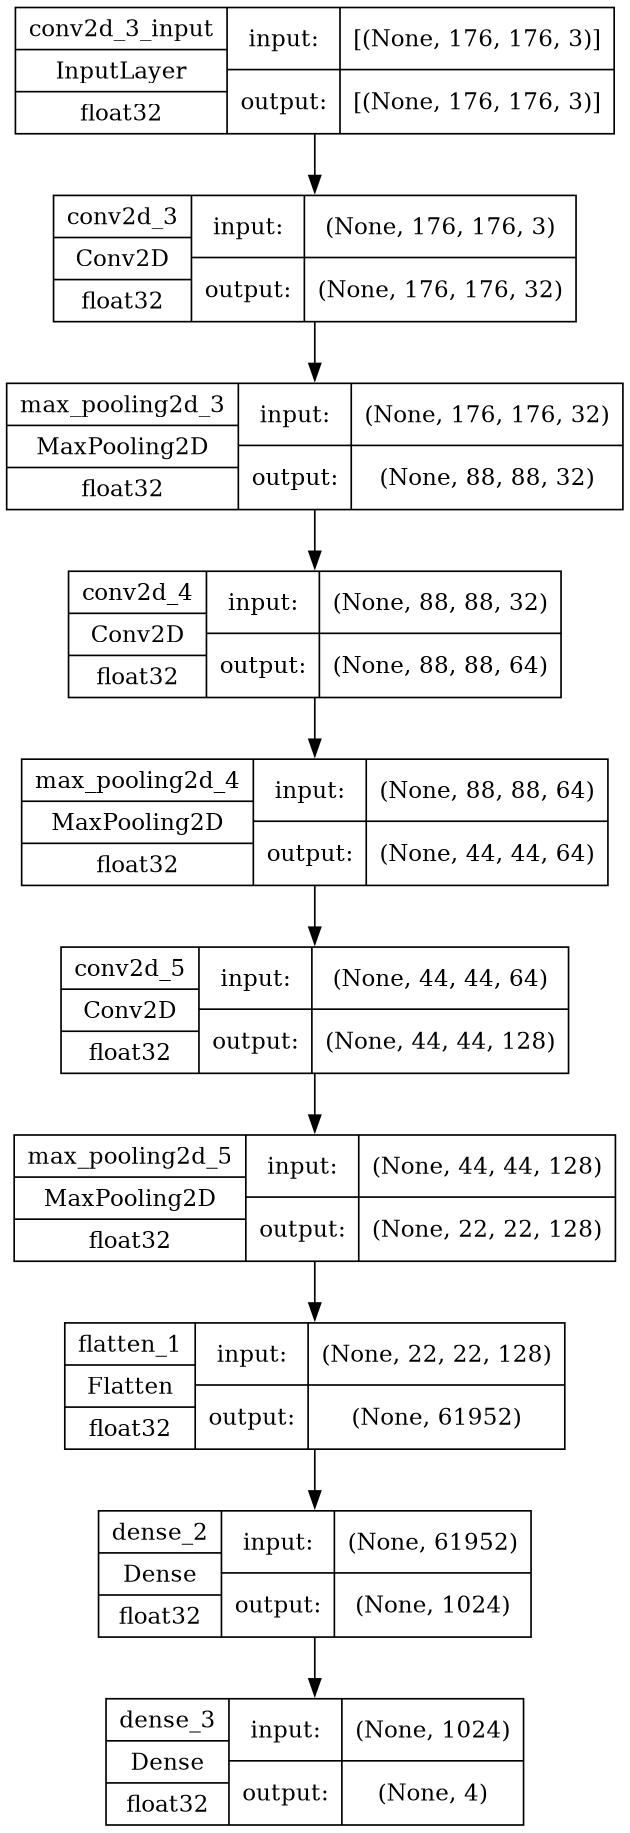

In [28]:
tf.keras.utils.plot_model(cnn_over, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [29]:
cnn_over.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
cnn_over.fit(x_train_over, Y_train_over, epochs=10)

Epoch 1/10
317/317 [==============================] - 15s 42ms/step - loss: 0.8235 - accuracy: 0.6500
Epoch 2/10
317/317 [==============================] - 13s 40ms/step - loss: 0.2769 - accuracy: 0.8904
Epoch 3/10
317/317 [==============================] - 13s 41ms/step - loss: 0.0945 - accuracy: 0.9663
Epoch 4/10
317/317 [==============================] - 13s 41ms/step - loss: 0.0582 - accuracy: 0.9805
Epoch 5/10
317/317 [==============================] - 13s 41ms/step - loss: 0.0387 - accuracy: 0.9872
Epoch 6/10
317/317 [==============================] - 13s 41ms/step - loss: 0.0240 - accuracy: 0.9912
Epoch 7/10
317/317 [==============================] - 13s 41ms/step - loss: 0.0188 - accuracy: 0.9939
Epoch 8/10
317/317 [==============================] - 13s 41ms/step - loss: 0.0117 - accuracy: 0.9960
Epoch 9/10
317/317 [==============================] - 13s 41ms/step - loss: 0.0068 - accuracy: 0.9975
Epoch 10/10
317/317 [==============================] - 13s 41ms/step - loss: 0.030

In [31]:
cnn_over.evaluate(x_test, Y_test)

40/40 [==============================] - 1s 13ms/step - loss: 0.3328 - accuracy: 0.9312


[0.33278679847717285, 0.9312499761581421]

40/40 [==============================] - 1s 12ms/step


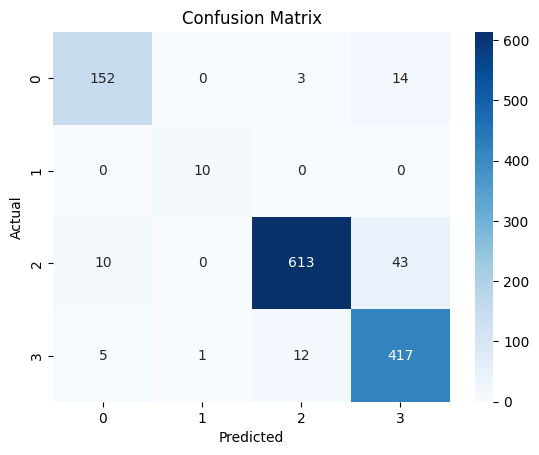

In [32]:
predictions = cnn_over.predict(x_test)
y_pred_over = np.argmax(predictions,axis=1)
y_test_over = np.argmax(Y_test,axis=1)
conf_matrix = confusion_matrix(y_test_over, y_pred_over)

# Plot confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_pred_over), yticklabels=np.unique(y_test_over))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [33]:
ClassificationReport = classification_report(y_test_over,y_pred_over)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.91      0.90      0.90       169
           1       0.91      1.00      0.95        10
           2       0.98      0.92      0.95       666
           3       0.88      0.96      0.92       435

    accuracy                           0.93      1280
   macro avg       0.92      0.94      0.93      1280
weighted avg       0.93      0.93      0.93      1280



# Adding dropout layers for overfitting

In [34]:
cnn_over_dropout = models.Sequential([
    # CNN layers
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(176, 176, 3)),
    layers.MaxPooling2D((2, 2), padding='same'),
    

    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), padding='same'),
    

    layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), padding='same'),
    

    # Dense layers
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),  # Add dropout before the output layer

    # Output layer
    layers.Dense(4, activation='softmax')
])
cnn_over_dropout.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 176, 176, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 88, 88, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 88, 88, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 44, 44, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 44, 44, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 22, 22, 128)      

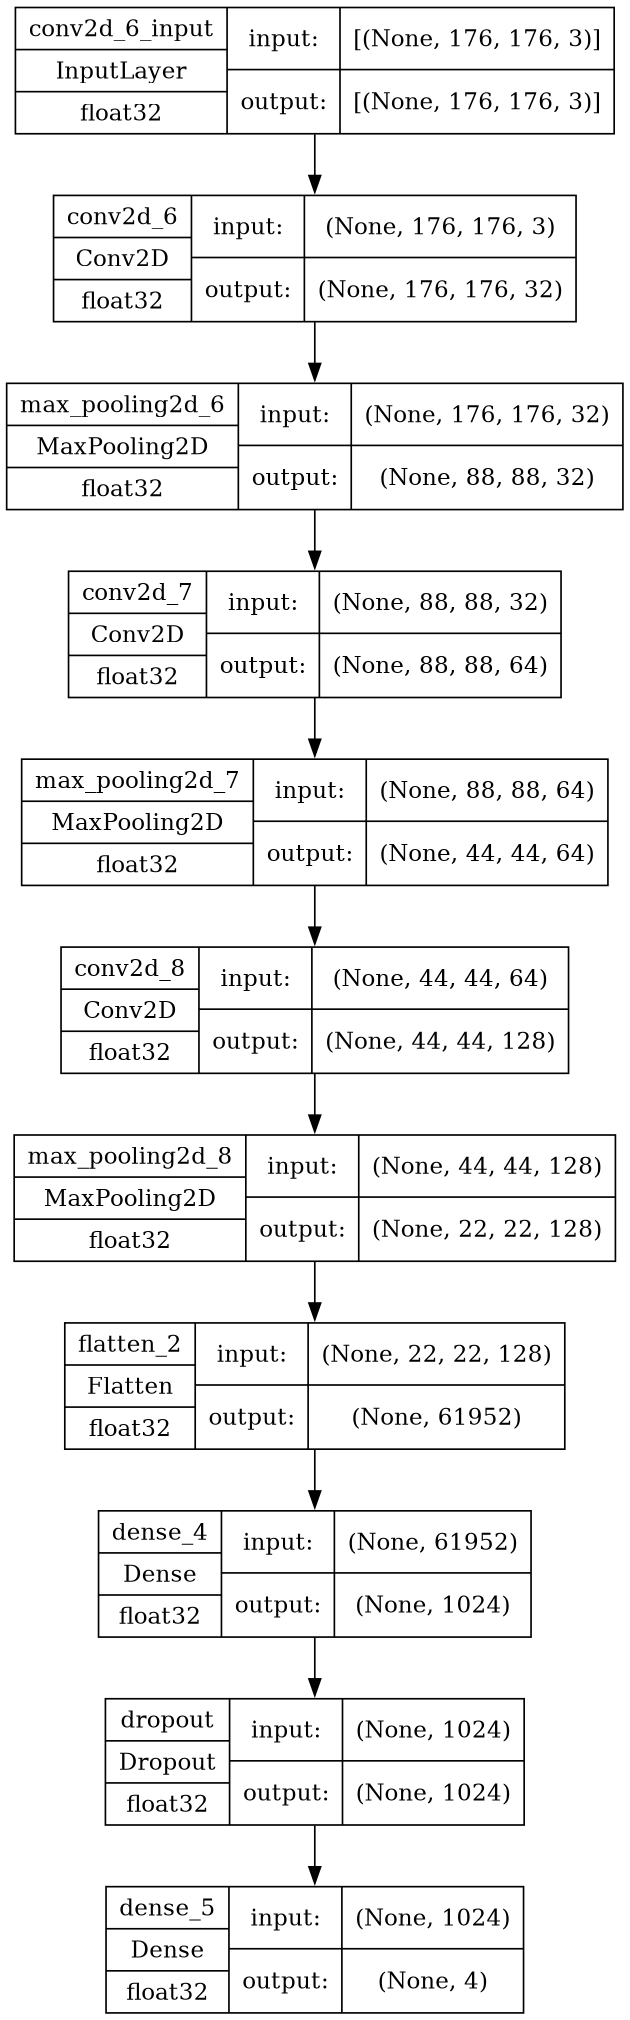

In [35]:
tf.keras.utils.plot_model(cnn_over_dropout, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [36]:
cnn_over_dropout.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
cnn_over_dropout.fit(x_train_over, Y_train_over, epochs=10)

Epoch 1/10
317/317 [==============================] - 15s 41ms/step - loss: 0.8759 - accuracy: 0.6074
Epoch 2/10
317/317 [==============================] - 13s 41ms/step - loss: 0.3711 - accuracy: 0.8440
Epoch 3/10
317/317 [==============================] - 14s 43ms/step - loss: 0.1774 - accuracy: 0.9316
Epoch 4/10
317/317 [==============================] - 13s 41ms/step - loss: 0.0772 - accuracy: 0.9716
Epoch 5/10
317/317 [==============================] - 13s 41ms/step - loss: 0.0549 - accuracy: 0.9824
Epoch 6/10
317/317 [==============================] - 13s 41ms/step - loss: 0.0247 - accuracy: 0.9912
Epoch 7/10
317/317 [==============================] - 13s 41ms/step - loss: 0.0340 - accuracy: 0.9885
Epoch 8/10
317/317 [==============================] - 13s 41ms/step - loss: 0.0232 - accuracy: 0.9920
Epoch 9/10
317/317 [==============================] - 13s 41ms/step - loss: 0.0203 - accuracy: 0.9931
Epoch 10/10
317/317 [==============================] - 13s 41ms/step - loss: 0.020

In [38]:
cnn_over_dropout.evaluate(x_test, Y_test)

40/40 [==============================] - 1s 14ms/step - loss: 0.2771 - accuracy: 0.9461


[0.27714136242866516, 0.946093738079071]

40/40 [==============================] - 1s 12ms/step


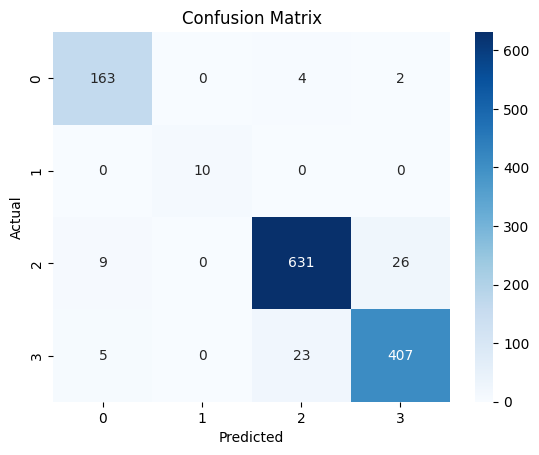

In [39]:
predictions = cnn_over_dropout.predict(x_test)
y_pred_over_dropout = np.argmax(predictions,axis=1)
y_test_over_dropout = np.argmax(Y_test,axis=1)
conf_matrix = confusion_matrix(y_test_over_dropout, y_pred_over_dropout)

# Plot confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_pred_over_dropout), yticklabels=np.unique(y_test_over_dropout))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [40]:
ClassificationReport = classification_report(y_test_over_dropout,y_pred_over_dropout)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.92      0.96      0.94       169
           1       1.00      1.00      1.00        10
           2       0.96      0.95      0.95       666
           3       0.94      0.94      0.94       435

    accuracy                           0.95      1280
   macro avg       0.95      0.96      0.96      1280
weighted avg       0.95      0.95      0.95      1280

